In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6.0)

# References
- [Optimizing Python with NumPy and Numba](https://jakevdp.github.io/blog/2015/02/24/optimizing-python-with-numpy-and-numba/)


# Bspline interpolator

- [De Boor's Algorithm - Wikipedia](https://en.wikipedia.org/wiki/De_Boor%27s_algorithm)

## Numpy

In [53]:
import numpy as np
#from numpy.fft import fft, ifft
from scipy.fftpack import fft, ifft # scipy fftpack is faster than numpy fft

def bspline_python(p, j, x):
        """Return the value at x in [0,1[ of the B-spline with 
        integer nodes of degree p with support starting at j.
        Implemented recursively using the de Boor's recursion formula"""
        assert (x >= 0.0) & (x <= 1.0)
        assert (type(p) == int) & (type(j) == int)
        if p == 0:
            if j == 0:
                return 1.0
            else:
                return 0.0
        else:
            w = (x - j) / p
            w1 = (x - j - 1) / p
        return w * bspline_python(p - 1, j, x) + (1 - w1) * bspline_python(p - 1, j + 1, x)

class BSplineNumpy:
    
    def __init__(self, p, xmin, xmax, ncells):
        assert p & 1 == 1  # check that p is odd
        self.p = p
        self.ncells = ncells
        # compute eigenvalues of degree p b-spline matrix
        self.modes = 2 * np.pi * np.arange(ncells) / ncells
        self.deltax = (xmax - xmin) / ncells
        
        self.eig_bspl = bspline_python(p, -(p + 1) // 2, 0.0)
        for j in range(1, (p + 1) // 2):
            self.eig_bspl += bspline_python(p, j - (p + 1) // 2, 0.0) * 2 * np.cos(j * self.modes)
            
        self.eigalpha = np.zeros(ncells, dtype=complex)
    
    def interpolate_disp(self, f, alpha):
        """compute the interpolating spline of degree p of odd degree 
        of a function f on a periodic uniform mesh, at
        all points xi-alpha"""
        p = self.p
        assert (np.size(f) == self.ncells)
        # compute eigenvalues of cubic splines evaluated at displaced points
        ishift = np.floor(-alpha / self.deltax)
        beta = -ishift - alpha / self.deltax
        self.eigalpha.fill(0.)
        for j in range(-(p-1)//2, (p+1)//2 + 1):
            self.eigalpha += bspline_python(p, j-(p+1)//2, beta) * np.exp((ishift+j)*1j*self.modes)
            
        # compute interpolating spline using fft and properties of circulant matrices
        return np.real(ifft(fft(f) * self.eigalpha / self.eig_bspl))


### Interpolation test
$\sin$ function after a displacement of alpha

255 µs ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


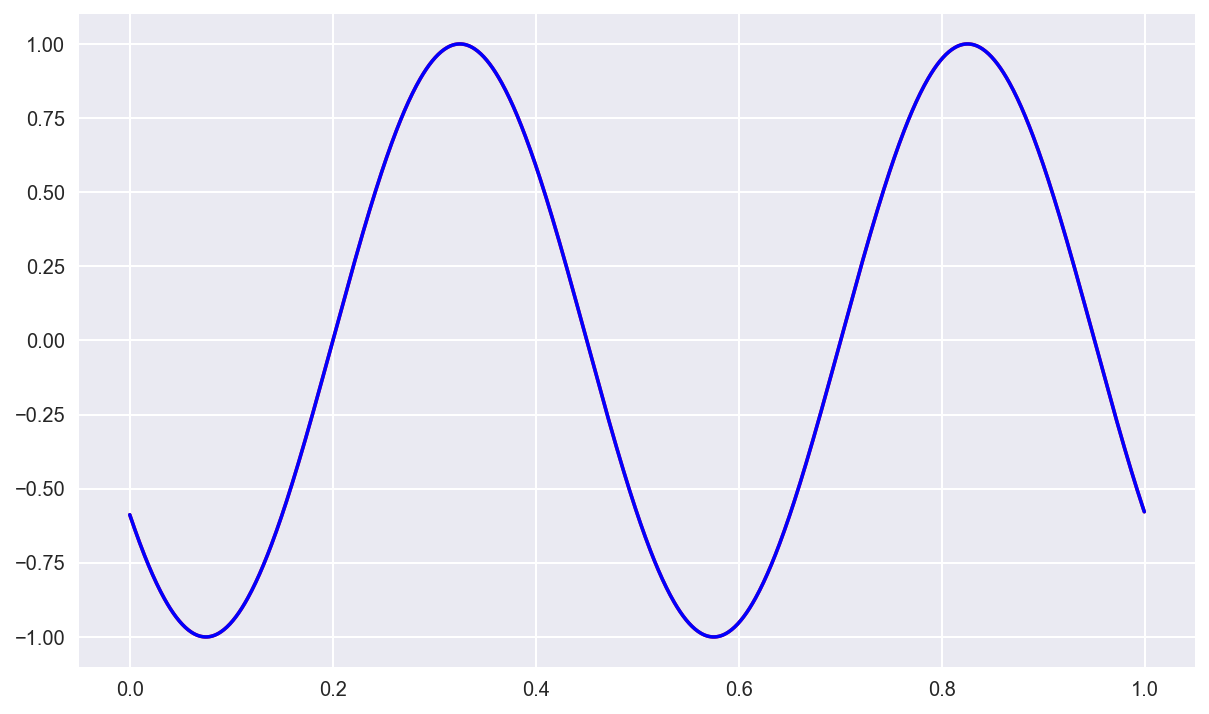

In [54]:
n =1024
cs = BSplineNumpy(3,0,1,n)
x = np.linspace(0,1,n, endpoint=False)
f = np.sin(x*4*np.pi)
alpha = 0.2
plt.plot( x, np.sin((x-alpha)*4*np.pi), 'r-', x, cs.interpolate_disp(f, alpha),'b-');
%timeit cs.interpolate_disp(f, alpha)

In [55]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [56]:
%lprun -s -f cs.interpolate_disp -T lp_results.txt cs.interpolate_disp(f, alpha)
%cat lp_results.txt 


*** Profile printout saved to text file 'lp_results.txt'. 
Timer unit: 1e-06 s

Total time: 0.001696 s
File: <ipython-input-53-c45f6143da2e>
Function: interpolate_disp at line 37

Line #      Hits         Time  Per Hit   % Time  Line Contents
    37                                               def interpolate_disp(self, f, alpha):
    38                                                   """compute the interpolating spline of degree p of odd degree 
    39                                                   of a function f on a periodic uniform mesh, at
    40                                                   all points xi-alpha"""
    41         1            3      3.0      0.2          p = self.p
    42         1            9      9.0      0.5          assert (np.size(f) == self.ncells)
    43                                                   # compute eigenvalues of cubic splines evaluated at displaced points
    44         1           24     24.0      1.4          ishift = np.floor(

# Fortran

In [34]:
%load_ext fortranmagic

The fortranmagic extension is already loaded. To reload it, use:
  %reload_ext fortranmagic


In [35]:
%%fortran

recursive function bspline_fortran(p, j, x) result(res)
    integer :: p, j
    real(8) :: x, w, w1
    if (p == 0) then
        if (j == 0) then
            res = 1.0
            return
        else
            res = 0.0
            return
        end if
    else
        w = (x - j) / p
        w1 = (x - j - 1) / p
    end if
    
    res = w * bspline_fortran(p-1,j,x) &
    +(1-w1)*bspline_fortran(p-1,j+1,x)

end function bspline_fortran


In [36]:
import numpy as np
#from numpy.fft import fft, ifft
from scipy.fftpack import fft, ifft # scipy version is faster than numpy

class BSplineFortran:
    
    def __init__(self, p, xmin, xmax, ncells):
        assert p & 1 == 1  # check that p is odd
        self.p = p
        self.ncells = ncells
        # compute eigenvalues of degree p b-spline matrix
        self.modes = 2 * np.pi * np.arange(ncells) / ncells
        self.deltax = (xmax - xmin) / ncells
        
        self.eig_bspl = bspline_fortran(p, -(p + 1) // 2, 0.0)
        for j in range(1, (p + 1) // 2):
            self.eig_bspl += bspline_fortran(p, j - (p + 1) // 2, 0.0) * 2 * np.cos(j * self.modes)
            
        self.eigalpha = np.zeros(ncells, dtype=complex)
    
    def interpolate_disp(self, f, alpha):
        """compute the interpolating spline of degree p of odd degree 
        of a function f on a periodic uniform mesh, at
        all points xi-alpha"""
        p = self.p
        assert (np.size(f) == self.ncells)
        # compute eigenvalues of cubic splines evaluated at displaced points
        ishift = np.floor(-alpha / self.deltax)
        beta = -ishift - alpha / self.deltax
        self.eigalpha.fill(0.)
        for j in range(-(p-1)//2, (p+1)//2 + 1):
            self.eigalpha += bspline_fortran(p, j-(p+1)//2, beta) * np.exp((ishift+j)*1j*self.modes)
            
        # compute interpolating spline using fft and properties of circulant matrices
        return np.real(np.fft.ifft(np.fft.fft(f) * self.eigalpha / self.eig_bspl))



### Interpolation test
$\sin$ function after a displacement of alpha

245 µs ± 7.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


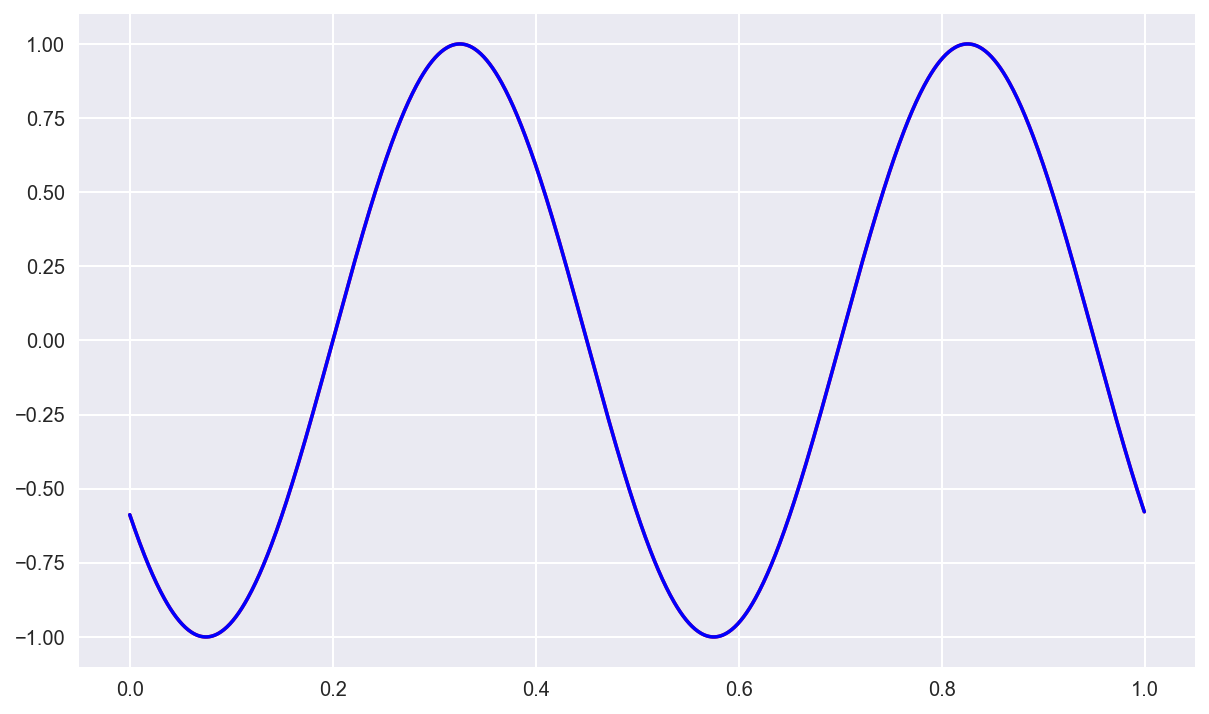

In [37]:
n =1024
cs = BSplineFortran(3,0,1,n)
x = np.linspace(0,1,n, endpoint=False)
f = np.sin(x*4*np.pi)
alpha = 0.2
plt.plot( x, np.sin((x-alpha)*4*np.pi), 'r-', x, cs.interpolate_disp(f, alpha),'b-');
%timeit cs.interpolate_disp(f, alpha)

## Numba

In [38]:
from numba import jit,  int32, float64
from scipy.fftpack import fft, ifft

@jit("float64(int32,int32,float64)",nopython=True)
def bspline_numba(p, j, x):
    
        """Return the value at x in [0,1[ of the B-spline with 
        integer nodes of degree p with support starting at j.
        Implemented recursively using the de Boor's recursion formula"""
        
        assert ((x >= 0.0) & (x <= 1.0))
        if p == 0:
            if j == 0:
                return 1.0
            else:
                return 0.0
        else:
            w = (x-j)/p
            w1 = (x-j-1)/p
        return w * bspline_numba(p-1,j,x)+(1-w1)*bspline_numba(p-1,j+1,x)

class BSplineNumba:
    
    def __init__(self, p, xmin, xmax, ncells):
        assert p & 1 == 1  # check that p is odd
        self.p = p
        self.ncells = ncells
        # compute eigenvalues of degree p b-spline matrix
        self.modes = 2 * np.pi * np.arange(ncells) / ncells
        self.deltax = (xmax - xmin) / ncells
        
        self.eig_bspl = bspline_numba(p, -(p+1)//2, 0.0)
        for j in range(1, (p + 1) // 2):
            self.eig_bspl += bspline_numba(p,j-(p+1)//2,0.0)*2*np.cos(j*self.modes)
            
        self.eigalpha = np.zeros(ncells, dtype=complex)
        
    def interpolate_disp(self, f, alpha):
        """compute the interpolating spline of degree p of odd degree 
        of a function f on a periodic uniform mesh, at
        all points xi-alpha"""
        
        p = self.p
        assert (np.size(f) == self.ncells)
        # compute eigenvalues of cubic splines evaluated at displaced points
        ishift = np.floor(-alpha / self.deltax)
        beta = -ishift - alpha / self.deltax
        self.eigalpha.fill(0.)
        for j in range(-(p-1)//2, (p+1)//2+1):
            self.eigalpha += bspline_numba(p, j-(p+1)//2, beta)*np.exp((ishift+j)*1j*self.modes)
            
        # compute interpolating spline using fft and properties of circulant matrices
        return np.real(ifft(fft(f) * self.eigalpha / self.eig_bspl))


193 µs ± 4.99 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


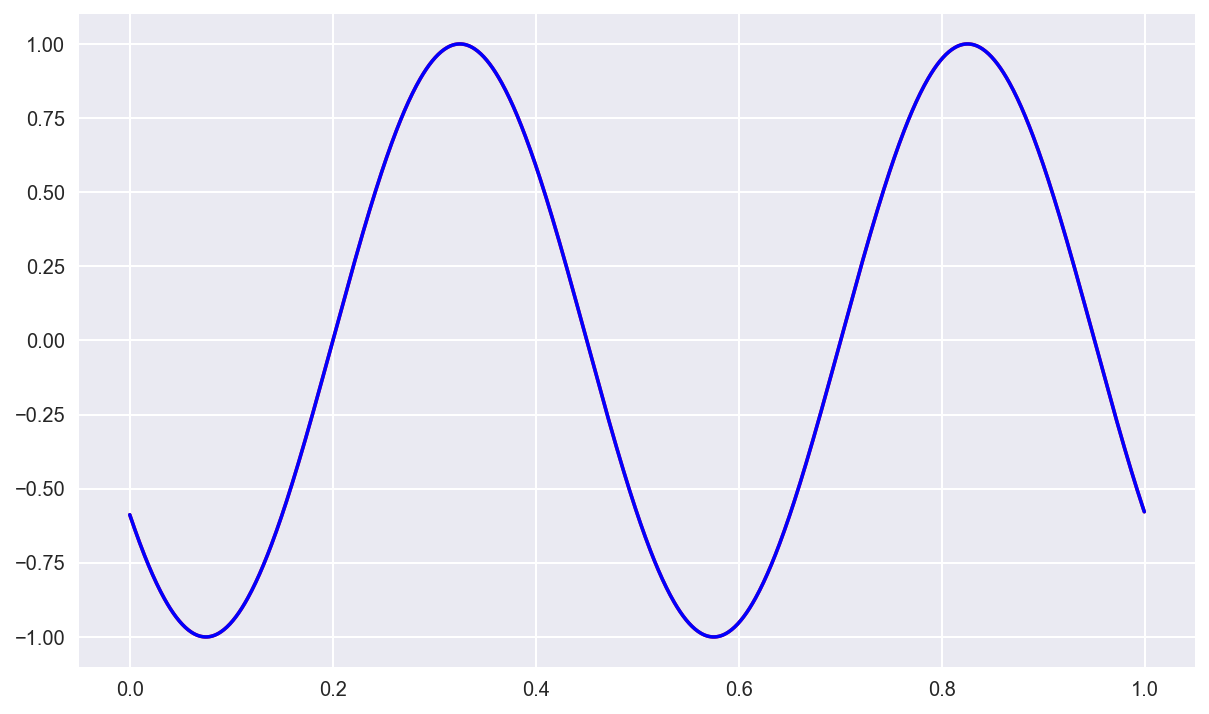

In [39]:
n =1024
cs = BSplineNumba(3,0,1,n)
x = np.linspace(0,1,n, endpoint=False)
f = np.sin(x*4*np.pi)
alpha = 0.2
plt.plot( x, np.sin((x-alpha)*4*np.pi), 'r', x, cs.interpolate_disp(f, alpha),'b');
%timeit cs.interpolate_disp(f, alpha)

## Cython

In [40]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [41]:
%%cython
import cython
import numpy as np
cimport numpy as np
from scipy.fftpack import fft, ifft

ctypedef np.float64_t dtype_t      # shorthand type. easy to change

cdef double bspline_cython(int p, int j, double x):
        """Return the value at x in [0,1[ of the B-spline with 
        integer nodes of degree p with support starting at j.
        Implemented recursively using the de Boor's recursion formula"""
        cdef double w
        cdef double w1
        assert ((x >= 0.0) & (x <= 1.0))
        if p == 0:
            if j == 0:
                return 1.0
            else:
                return 0.0
        else:
            w = (x - j) / p
            w1 = (x - j - 1) / p
        return w * bspline_cython(p-1,j,x)+(1-w1)*bspline_cython(p-1,j+1,x)

class BSplineCython:
    
    def __init__(self, p, xmin, xmax, ncells):
        assert p & 1 == 1  # check that p is odd
        self.p = p
        self.ncells = ncells
        # compute eigenvalues of degree p b-spline matrix
        self.modes = 2 * np.pi * np.arange(ncells) / ncells
        self.deltax = (xmax - xmin) / ncells
        
        self.eig_bspl = bspline_cython(p,-(p+1)//2, 0.0)
        for j in range(1, (p + 1) // 2):
            self.eig_bspl += bspline_cython(p,j-(p+1)//2,0.0)*2*np.cos(j*self.modes)
            
        self.eigalpha = np.zeros(ncells, dtype=complex)
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.nonecheck(False)
    @cython.profile(False)
    @cython.cdivision(True)
    def interpolate_disp(self, np.ndarray[dtype_t, ndim=1] f, double alpha):
        """compute the interpolating spline of degree p of odd degree 
        of a function f on a periodic uniform mesh, at
        all points xi-alpha"""
        cdef int p
        cdef int ishift
        cdef double beta
        cdef Py_ssize_t j
        p = self.p
        assert (np.size(f) == self.ncells)
        # compute eigenvalues of cubic splines evaluated at displaced points
        ishift = np.floor(-alpha / self.deltax)
        beta = -ishift - alpha / self.deltax
        self.eigalpha.fill(0.)
        for j in range(-(p-1)//2, (p+1)//2+1):
            self.eigalpha += bspline_cython(p,j-(p+1)//2,beta)*np.exp((ishift+j)*1j*self.modes)
            
        # compute interpolating spline using fft and properties of circulant matrices
        return np.real(ifft(fft(f) * self.eigalpha / self.eig_bspl))


168 µs ± 8.56 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


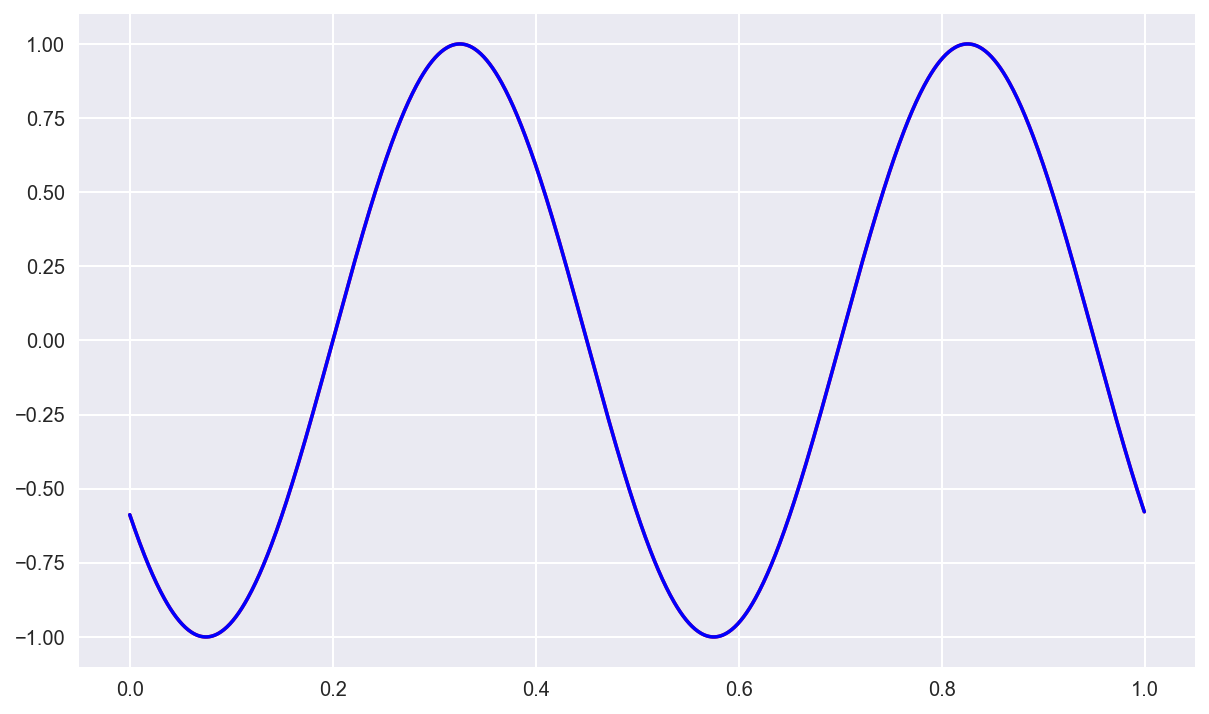

In [42]:
n =1024
cs = BSplineCython(3,0,1,n)
x = np.linspace(0,1,n, endpoint=False)
f = np.sin(x*4*np.pi)
alpha = 0.2
plt.plot( x, np.sin((x-alpha)*4*np.pi), 'r', x, cs.interpolate_disp(f, alpha),'b');
%timeit cs.interpolate_disp(f, alpha)

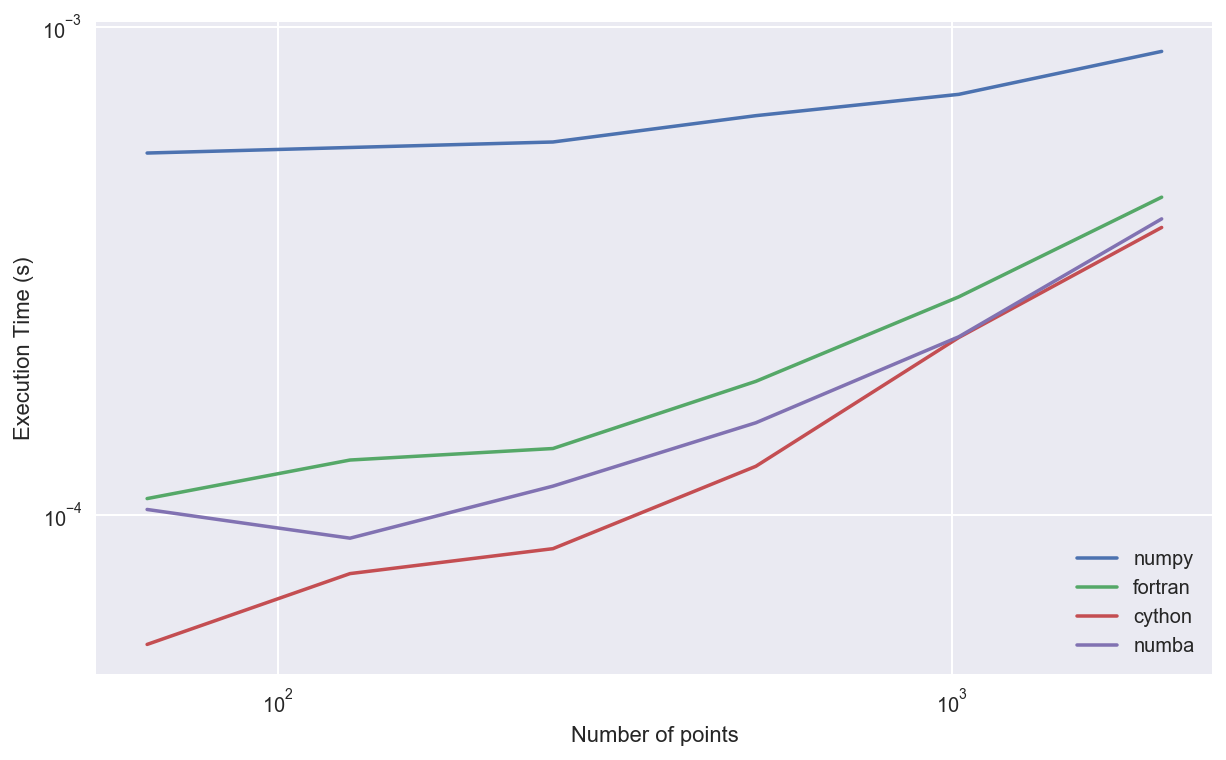

In [43]:
import seaborn; seaborn.set()
Mrange = (2 ** np.arange(6, 12)).astype(int)

t_numpy = []
t_fortran = []
t_cython = []
t_numba = []

for M in Mrange:
    x = np.linspace(0,1,M, endpoint=False)
    f = np.sin(x*4*np.pi)
    cs1 = BSplineNumpy(5,0,1,M)
    cs2 = BSplineFortran(5,0,1,M)
    cs3 = BSplineCython(5,0,1,M)
    cs4 = BSplineNumba(5,0,1,M)
    
    alpha = 0.1
    t1 = %timeit -oq cs1.interpolate_disp(f, alpha)
    t2 = %timeit -oq cs2.interpolate_disp(f, alpha)
    t3 = %timeit -oq cs3.interpolate_disp(f, alpha)
    t4 = %timeit -oq cs4.interpolate_disp(f, alpha)
    
    t_numpy.append(t1.best)
    t_fortran.append(t2.best)
    t_cython.append(t3.best)
    t_numba.append(t4.best)
    
plt.loglog(Mrange, t_numpy, label='numpy')
plt.loglog(Mrange, t_fortran, label='fortran')
plt.loglog(Mrange, t_cython, label='cython')
plt.loglog(Mrange, t_numba, label='numba')
plt.legend(loc='lower right')
plt.xlabel('Number of points')
plt.ylabel('Execution Time (s)');

# Semi-Lagrangian method

Let us consider an abstract scalar advection equation of the form
$$
\frac{\partial f}{\partial t}+ a(x, t) \cdot \nabla f = 0. 
$$
The characteristic curves associated to this equation are the solutions of the ordinary differential equations
$$
\frac{dX}{dt} = a(X(t), t)
$$
We shall denote by $X(t, x, s)$ the unique solution of this equation associated to the initial condition $X(s) = x$.

The classical semi-Lagrangian method is based on a backtracking of characteristics. Two steps are needed to update the distribution function $f^{n+1}$ at $t^{n+1}$ from its value $f^n$ at time $t^n$ :
1. For each grid point $x_i$ compute $X(t^n; x_i, t^{n+1})$ the value of the characteristic at $t^n$ which takes the value $x_i$ at $t^{n+1}$.
2. As the distribution solution of first equation verifies 
$$f^{n+1}(x_i) = f^n(X(t^n; x_i, t^{n+1})),$$
we obtain the desired value of $f^{n+1}(x_i)$ by computing $f^n(X(t^n;x_i,t^{n+1})$ by interpolation as $X(t^n; x_i, t^{n+1})$ is in general not a grid point.

*[Eric Sonnendrucker - Numerical methods for the Vlasov equations](http://www-m16.ma.tum.de/foswiki/pub/M16/Allgemeines/NumMethVlasov/Num-Meth-Vlasov-Notes.pdf)*

# Vlasov-Poisson equation
We consider the dimensionless Vlasov-Poisson equation for one species
with a neutralizing background.

$$ 
\frac{\partial f}{\partial t}+ v\cdot \nabla_x f + E(t,x) \cdot \nabla_v f = 0, \\
- \Delta \phi = 1 - \rho, E = - \nabla \phi \\
\rho(t,x)  =  \int f(t,x,v)dv.
$$

- [Vlasov Equation - Wikipedia](https://en.wikipedia.org/wiki/Vlasov_equation)

In [44]:
from numpy.fft import rfft, irfft

BSpline = dict(numpy=BSplineNumpy,
               fortran=BSplineFortran,
               cython=BSplineCython,
               numba=BSplineNumba)

class VlasovPoisson:
    
    def __init__(self, xmin, xmax, nx, vmin, vmax, nv, opt='numpy'):
        
        self.nx = nx
        self.x, self.dx = np.linspace(xmin, xmax, nx, endpoint=False, retstep=True)
        self.nv = nv
        self.v, self.dv = np.linspace(vmin, vmax, nv, endpoint=False, retstep=True)
        self.f = np.zeros((nx,nv)) 
        BSplineClass = BSpline[opt]
        self.cs_x = BSplineClass(3, xmin, xmax, nx)
        self.cs_v = BSplineClass(3, vmin, vmax, nv)
        self.modes = 2 * np.pi * (np.arange(nx/2+1)) / (xmax - xmin)
        self.modes[0] = 1.  # avoid division by 0
        self.xmin = xmin
        self.xmax = xmax
        self.vmin = vmin
        self.vmax = vmax
        
    def advection_x(self, dt):
        for j in range(self.nv):
            alpha = dt * self.v[j]
            self.f[:,j] = self.cs_x.interpolate_disp(self.f[:,j], alpha)
            
    def advection_v(self, e, dt):
        for i in range(self.nx):
            alpha = dt * e[i] 
            self.f[i,:] = self.cs_v.interpolate_disp(self.f[i,:], alpha)
            
    def compute_rho(self):
        return  self.dv * np.sum(self.f, axis=1)
            
    def compute_e(self, rho):
        # compute Ex using that ik*Ex = rho
        rhok = rfft(rho)
        return irfft(-1j*rhok/self.modes)
    
    def run(self, f, nstep, dt):
        self.f = f
        nrj = []
        self.advection_x(0.5*dt)
        for istep in range(nstep):
            rho = self.compute_rho()
            e = self.compute_e(rho)
            self.advection_v(e, dt)
            self.advection_x(dt)
            nrj.append( 0.5*np.log(np.sum(e*e)*sim.dx))
                
        return nrj

# Landau Damping

[Landau damping - Wikipedia](https://en.wikipedia.org/wiki/Landau_damping)

 numpy        : 9.3889 
 fortran      : 5.7361 
 numba        : 3.7452 
 cython       : 2.9805 


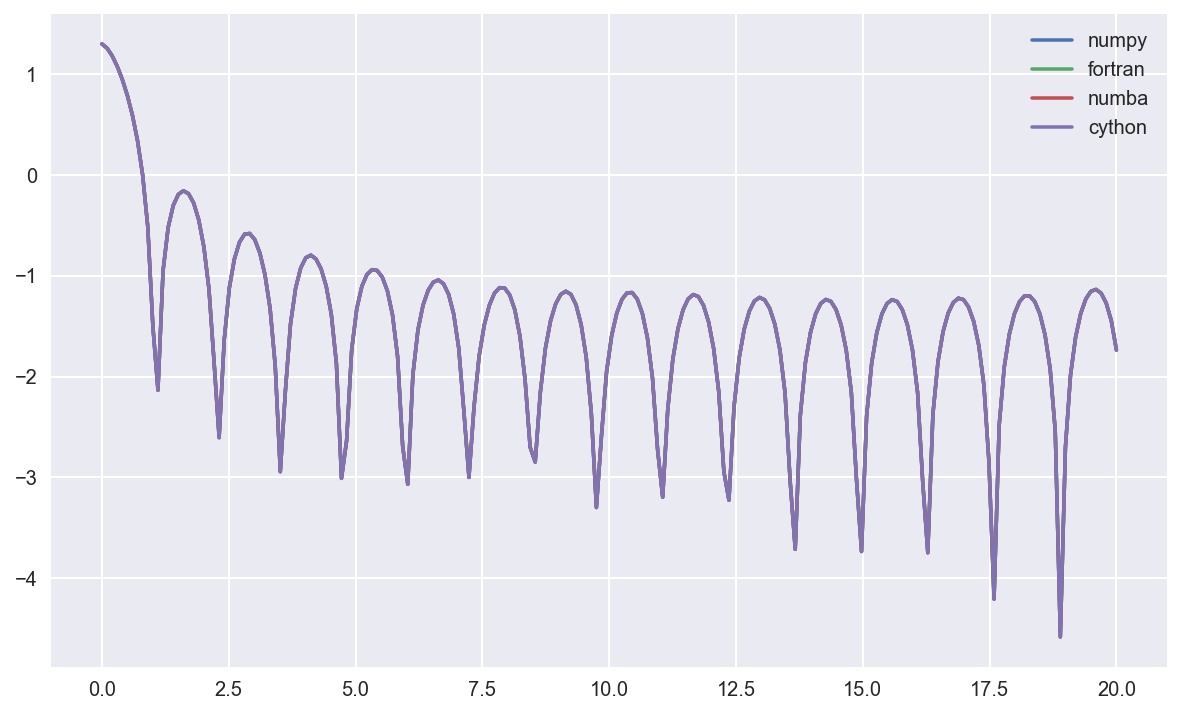

In [45]:
from time import time

elapsed_time = {}
fig, axes = plt.subplots()
for opt in ['numpy', 'fortran', 'numba', 'cython']:
    
    # Set grid
    nx, nv = 128, 128
    xmin, xmax = 0.0, 4*np.pi
    vmin, vmax = -6., 6.
    
    # Create Vlasov-Poisson simutlation
    sim = VlasovPoisson(xmin, xmax, nx, vmin, vmax, nv, opt=opt)

    # Initialize distribution function
    X, V = np.meshgrid(sim.x, sim.v)
    eps, kx = 0.05, 0.5
    f = (1.0+eps*np.cos(kx*X))/(2.0*np.pi)* np.exp(-0.5*V*V)

    # Set time domain
    nstep = 200
    t, dt = np.linspace(0.0, 20.0, nstep, retstep=True)
    
    # Run simulation
    etime = time()
    nrj = sim.run(f, nstep, dt)
    print(" {0:12s} : {1:.4f} ".format(opt, time()-etime))
    
    # Plot energy
    axes.plot(t, nrj, label=opt)

plt.legend();

# Parallelization with Cython

In [46]:
%%cython
import numpy as np
cimport numpy as np
from scipy.fftpack import fft, ifft

cdef double bspline(int p, int j, double x) nogil:
    """Return the value at x in [0,1[ of the B-spline with 
    integer nodes of degree p with support starting at j.
    Implemented recursively using the de Boor's recursion formula"""
    cdef double w, w1
    if p == 0:
        if j == 0:
            return 1.0
        else:
            return 0.0
    else:
        w = (x - j) / p
        w1 = (x - j - 1) / p
        
    return w * bspline(p - 1, j, x) + (1 - w1) * bspline(p - 1, j + 1, x)

cdef np.ndarray[np.float64_t, ndim=1] interp_disp(int p, np.ndarray[np.float64_t, ndim=1] f, int ncells, double deltax, double alpha):
    """compute the interpolating spline of degree p of odd degree of a function f on a periodic uniform mesh, at
    all points xi-alpha"""
    cdef Py_ssize_t j
    cdef int ishift
    cdef double beta
    assert (p & 1 == 1)  # check that p is odd
    n = np.size(f)
    assert (n == ncells)
    # compute eigenvalues of degree p b-spline matrix
    modes = 2 * np.pi * (np.arange(n)) / n
    eig_bspl = bspline(p, -(p + 1) // 2, 0.0)
    for j in range(1, (p + 1) // 2):
        eig_bspl += bspline(p, j - (p + 1) // 2, 0.0) * 2 * np.cos(j * modes)
    # compute eigenvalues of cubic splines evaluated at displaced points
    ishift = np.floor(-alpha / deltax)
    beta = -ishift - alpha / deltax
    eigalpha = np.zeros(n, dtype=complex)
    for j in range(-(p - 1) // 2, (p + 1) // 2 + 1):
        eigalpha += bspline(p, j - (p + 1) // 2, beta) * np.exp((ishift + j) * 1j * modes)
    # compute interpolating spline using fft and properties of circulant matrices
    interpSpline = np.real(ifft(fft(f) * eigalpha / eig_bspl))
    return interpSpline



In [47]:
from numpy.fft import rfft, irfft
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import cpu_count

class VlasovPoissonParallel(VlasovPoisson):
    
    def __init__(self, xmin, xmax, nx, vmin, vmax, nv, nthreads=cpu_count()):
        
        self.nx = nx
        self.x, self.dx = np.linspace(xmin, xmax, nx, endpoint=False, retstep=True)
        self.nv = nv
        self.v, self.dv = np.linspace(vmin, vmax, nv, endpoint=False, retstep=True)
        self.f = np.zeros((nx,nv))
        self.modes = 2 * np.pi * (np.arange(nx/2+1)) / (xmax - xmin)
        self.modes[0] = 1.  # avoid division by 0
        self.nthreads = nthreads
                
    def advection_x(self, dt):
        for j in range(self.nv):
            alpha = dt * self.v[j]
            self.f[:,j] = interp_disp(3, self.f[:,j], self.nx, self.dx, alpha)
            
    def advection_v(self, e, dt):
        for i in range(self.nx):
            alpha = dt * e[i] 
            self.f[i,:] = interp_disp(3, self.f[i,:], self.nv, self.dv, alpha)
                

 futures      : 5.7114 


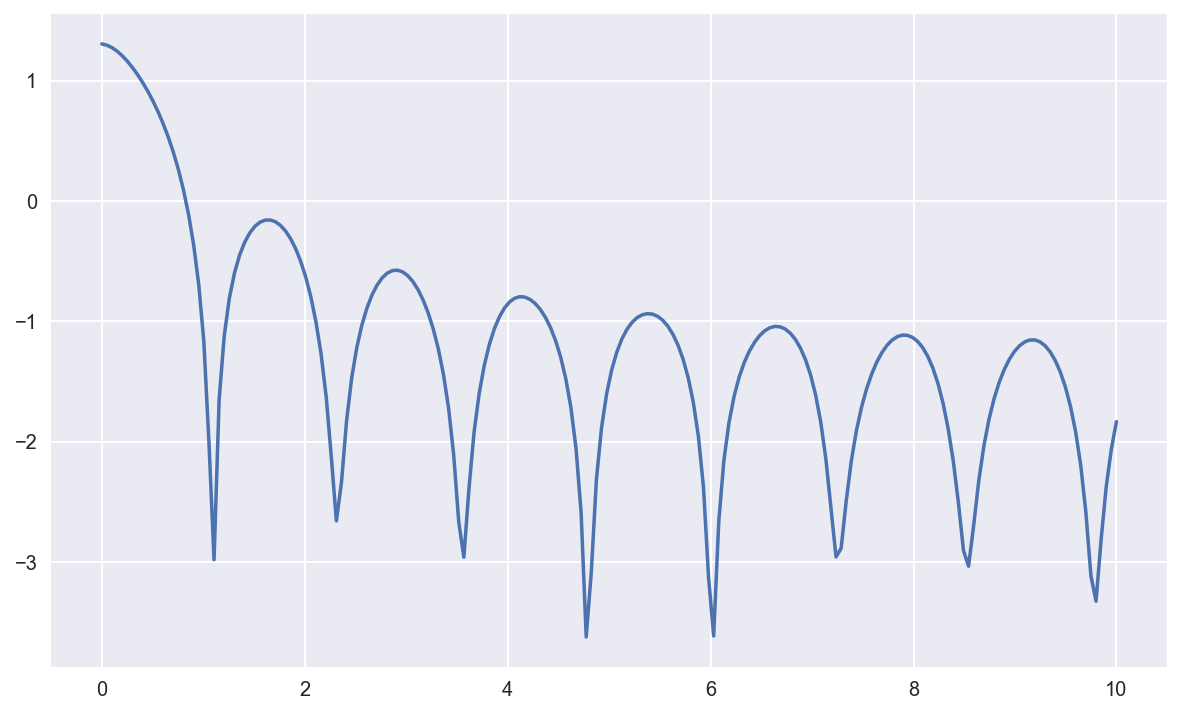

In [149]:
from time import time

elapsed_time = {}

# Set grid
nx, nv = 128, 128
xmin, xmax = 0.0, 4*np.pi
vmin, vmax = -6., 6.
    
# Create Vlasov-Poisson simutlation
sim = VlasovPoissonParallel(xmin, xmax, nx, vmin, vmax, nv, nthreads=4)

# Initialize distribution function
X, V = np.meshgrid(sim.x, sim.v)
eps, kx = 0.05, 0.5
f = (1.0+eps*np.cos(kx*X))/(2.0*np.pi)* np.exp(-0.5*V*V)

# Set time domain
nstep = 200
t, dt = np.linspace(0.0, 10.0, nstep, retstep=True)
    
# Run simulation
etime = time()
nrj = sim.run(f, nstep, dt)
print(" {0:12s} : {1:.4f} ".format("futures", time()-etime))
    
# Plot energy
plt.plot(t, nrj);